In [65]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers


# The names will be the names of each column in our pandas DataFrame
names = ['age', 'sex', 'chestpaintype', 'restingbp', 'chol', 'fbs', 'restecg', 'maxhr', 'exang', 'oldpeak', 'slope']

# Read the CSV

data = pd.read_csv('/content/heart.csv')

# Considering only heart patients
data = data[data['HeartDisease'] != 0]

# dropping the last column
data = data.drop(columns=['HeartDisease'])

In [66]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat
11,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat
13,49,M,ASY,140,234,0,Normal,140,Y,1.0,Flat


In [67]:
# print the last twenty or so data points
data.loc[280:]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
281,49,M,ASY,150,222,0,Normal,122,N,2.0,Flat
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat
...,...,...,...,...,...,...,...,...,...,...,...
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat


In [68]:
# Data Imputation
DI = data.copy()

for Fi in DI.columns:
    if DI[Fi].isna().sum() > 0.6 * len(DI):
        # Drop the column if majority values are missing
        DI = DI.drop(columns=[Fi])
    elif DI[Fi].dtype == 'object' and DI[Fi].isna().sum() < 0.4 * len(DI):
        # Fill missing categorical values with the majority label
        DI[Fi].replace('?', DI[Fi].mode().iloc[0], inplace=True)  # Replace '?' with the majority label
        DI[Fi].fillna(DI[Fi].mode().iloc[0], inplace=True)  # Fill remaining missing categorical values
    elif DI[Fi].dtype != 'object' and DI[Fi].isna().sum() < 0.4 * len(DI):
        # Fill missing numeric values with the median
        DI[Fi].replace('?', DI[Fi].median(), inplace=True)  # Replace '?' with the median
        DI[Fi].fillna(DI[Fi].median(), inplace=True)  # Fill remaining missing numeric values


# # Update the original data with imputed values
data.update(DI)
# print the last twenty or so data points with imputed value
data.loc[280:]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
281,49,M,ASY,150,222,0,Normal,122,N,2.0,Flat
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat
...,...,...,...,...,...,...,...,...,...,...,...
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat


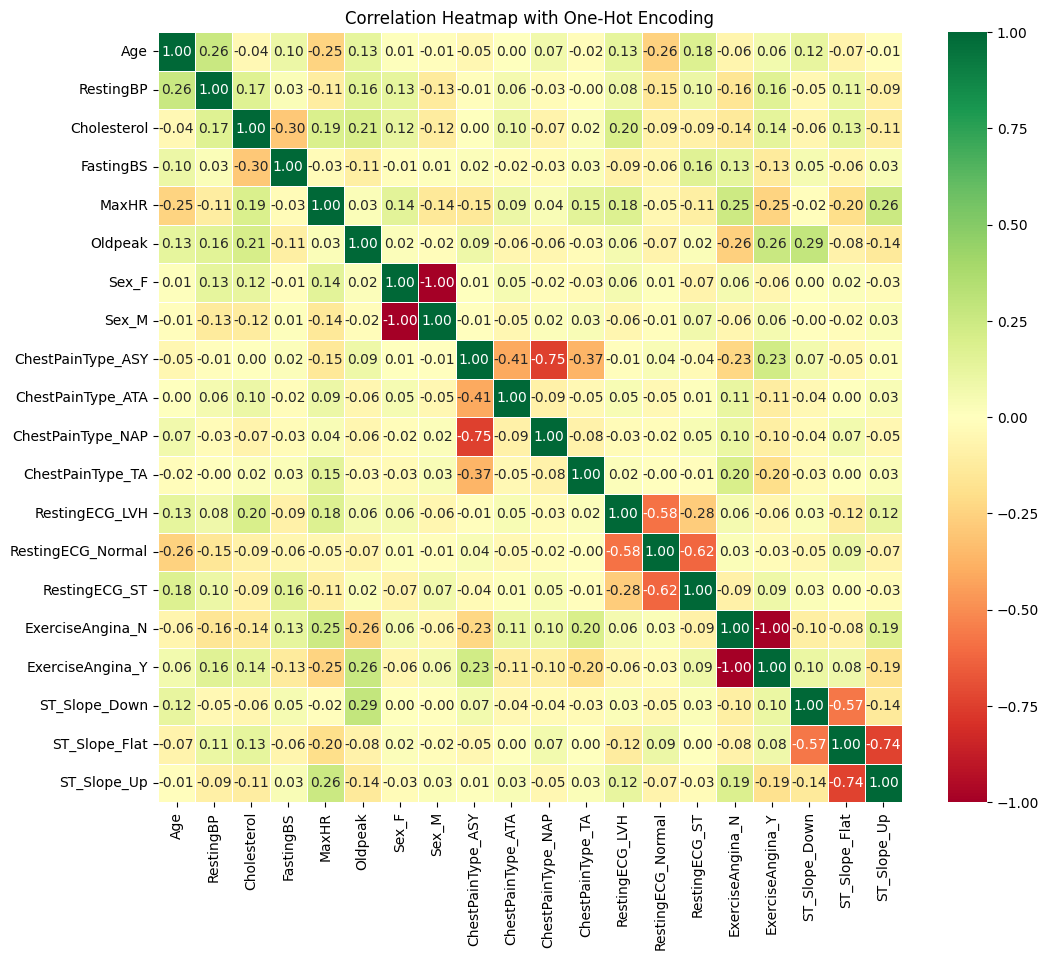

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame with both categorical and numerical features
# Apply one-hot encoding to categorical variables
df_encoded = pd.get_dummies(data)

# Generate correlation matrix
corr_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with One-Hot Encoding")
plt.show()


In [57]:
# Dataset Stratification HoldOut
val_ratio = 0.275
IH, IN = train_test_split(data.index, test_size=val_ratio, stratify=data['ChestPainType'])

IVH_idx = data.loc[IH].sample(frac=val_ratio).index
ITH_idx = IH.drop(IVH_idx)

IVN_idx = data.loc[IN].sample(frac=val_ratio).index
ITN_idx = IN.drop(IVN_idx)


train_data = data.loc[ITH_idx.append(ITN_idx)]
validation_data = data.loc[IVH_idx.append(IVN_idx)]
num_rows_train = train_data.shape[0]
num_rows_validation = validation_data.shape[0]

print("Number of rows in train_data:", num_rows_train)
print("Number of rows in validation_data:", num_rows_validation)


Number of rows in train_data: 369
Number of rows in validation_data: 139


In [58]:
print(train_data['ChestPainType'].value_counts())
print(validation_data['ChestPainType'].value_counts())

ASY    285
NAP     52
ATA     18
TA      14
Name: ChestPainType, dtype: int64
ASY    107
NAP     20
ATA      6
TA       6
Name: ChestPainType, dtype: int64


In [59]:
# Define categorical features
categorical_features = ['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Convert categorical features to categorical type
train_data[categorical_features] = train_data[categorical_features].astype('category')

# Separate features and labels
X = train_data.drop('ChestPainType', axis=1)
y = train_data['ChestPainType']

# Convert categorical labels to numerical form
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=np.number))

# One-hot encode categorical features
X_categorical = pd.get_dummies(X[categorical_features])

# Concatenate scaled numerical features with one-hot encoded categorical features
X_final = np.concatenate([X_scaled, X_categorical], axis=1)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_final.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(train_data['ChestPainType'].unique()), activation='softmax')  # Output layer with softmax activation for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_final, y_encoded, epochs=100, batch_size=10, verbose=2)


Epoch 1/100
37/37 - 1s - loss: 0.8108 - accuracy: 0.7724 - 768ms/epoch - 21ms/step
Epoch 2/100
37/37 - 0s - loss: 0.7318 - accuracy: 0.7724 - 67ms/epoch - 2ms/step
Epoch 3/100
37/37 - 0s - loss: 0.7030 - accuracy: 0.7724 - 74ms/epoch - 2ms/step
Epoch 4/100
37/37 - 0s - loss: 0.6797 - accuracy: 0.7724 - 66ms/epoch - 2ms/step
Epoch 5/100
37/37 - 0s - loss: 0.6669 - accuracy: 0.7724 - 71ms/epoch - 2ms/step
Epoch 6/100
37/37 - 0s - loss: 0.6530 - accuracy: 0.7724 - 62ms/epoch - 2ms/step
Epoch 7/100
37/37 - 0s - loss: 0.6350 - accuracy: 0.7751 - 62ms/epoch - 2ms/step
Epoch 8/100
37/37 - 0s - loss: 0.6233 - accuracy: 0.7751 - 61ms/epoch - 2ms/step
Epoch 9/100
37/37 - 0s - loss: 0.6134 - accuracy: 0.7751 - 64ms/epoch - 2ms/step
Epoch 10/100
37/37 - 0s - loss: 0.6030 - accuracy: 0.7778 - 59ms/epoch - 2ms/step
Epoch 11/100
37/37 - 0s - loss: 0.5928 - accuracy: 0.7778 - 68ms/epoch - 2ms/step
Epoch 12/100
37/37 - 0s - loss: 0.5799 - accuracy: 0.7778 - 58ms/epoch - 2ms/step
Epoch 13/100
37/37 - 0s

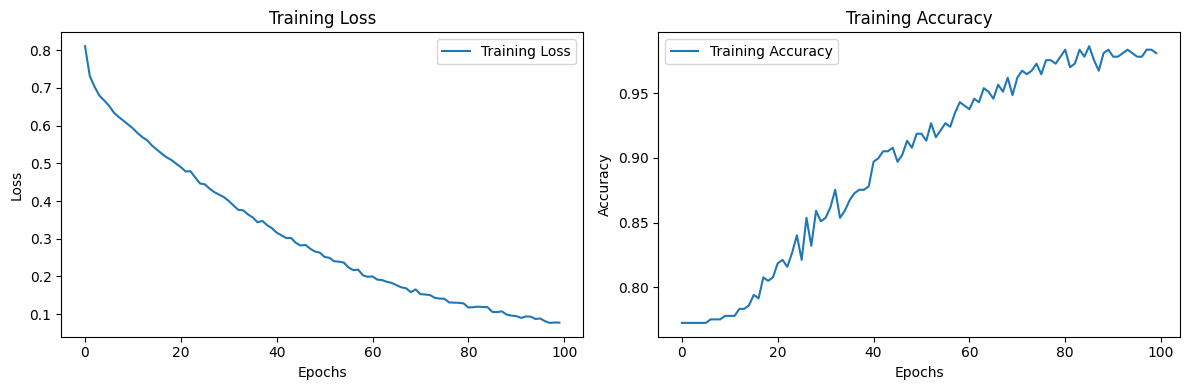

In [60]:
# Plotting the learning curve
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
from tensorflow.keras.models import load_model

# Convert categorical features to categorical type
validation_data[categorical_features] = validation_data[categorical_features].astype('category')

# Separate features and labels
X_test = validation_data.drop('ChestPainType', axis=1)
y_test = validation_data['ChestPainType']

# Convert categorical labels to numerical form
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Standardize numerical features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.select_dtypes(include=np.number))

# One-hot encode categorical features
X_test_categorical = pd.get_dummies(X_test[categorical_features])

X_val_final = np.concatenate([X_test_scaled, X_test_categorical], axis=1)

y_val_encoded = label_encoder.transform(validation_data['ChestPainType'])
y_val_pred = np.argmax(model.predict(X_val_final), axis=1)
accuracy_val = accuracy_score(y_val_encoded, y_val_pred)
print(f"Validation Accuracy: {accuracy_val*100:.2f}%")


5/5 [==============================] - 0s 3ms/step
Validation Accuracy: 95.68%


In [62]:
from sklearn.metrics import f1_score, classification_report

# Predictions
y_val_probabilities = model.predict(X_val_final)
y_val_pred = np.argmax(y_val_probabilities, axis=1)

# F1 Score
f1 = f1_score(y_val_encoded, y_val_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Classification Report
class_report = classification_report(y_val_encoded, y_val_pred)
print("Classification Report:")
print(class_report)


5/5 [==============================] - 0s 3ms/step
F1 Score: 0.9570
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.71      0.83      0.77         6
           2       0.94      0.85      0.89        20
           3       1.00      1.00      1.00         6

    accuracy                           0.96       139
   macro avg       0.91      0.92      0.91       139
weighted avg       0.96      0.96      0.96       139



5/5 [==============================] - 0s 4ms/step
F1 Score: 0.9570
Classification Report:
{'ASY': {'precision': 0.9722222222222222, 'recall': 0.9813084112149533, 'f1-score': 0.9767441860465117, 'support': 107}, 'ATA': {'precision': 0.7142857142857143, 'recall': 0.8333333333333334, 'f1-score': 0.7692307692307692, 'support': 6}, 'NAP': {'precision': 0.9444444444444444, 'recall': 0.85, 'f1-score': 0.8947368421052632, 'support': 20}, 'TA': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9568345323741008, 'macro avg': {'precision': 0.9077380952380952, 'recall': 0.9161604361370717, 'f1-score': 0.910177949345636, 'support': 139}, 'weighted avg': {'precision': 0.9582905104487839, 'recall': 0.9568345323741008, 'f1-score': 0.9569910026220622, 'support': 139}}


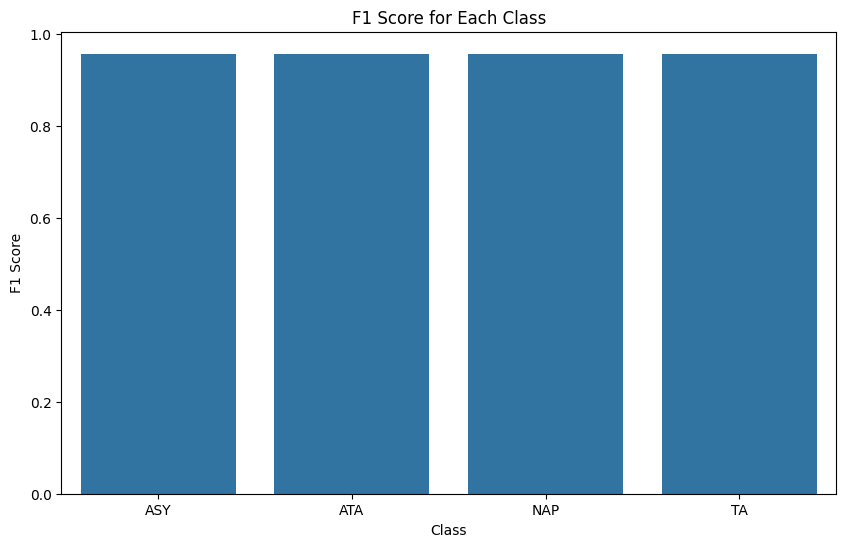

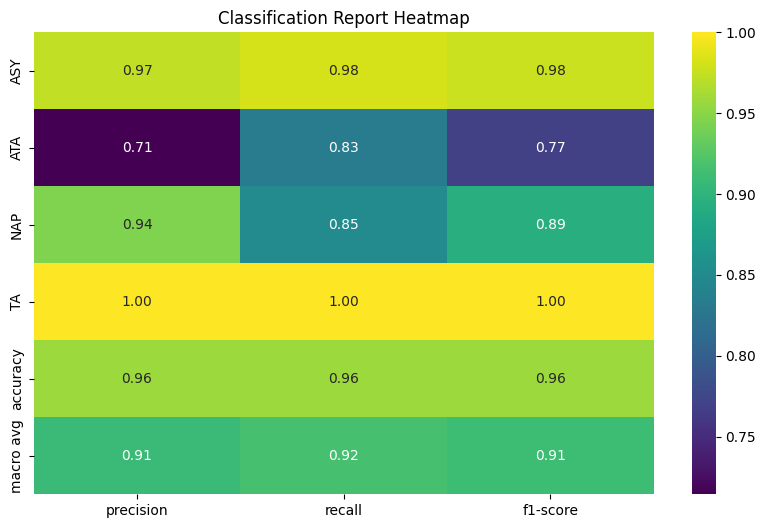

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_val_probabilities = model.predict(X_val_final)
y_val_pred = np.argmax(y_val_probabilities, axis=1)

# F1 Score
f1 = f1_score(y_val_encoded, y_val_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Classification Report
class_report = classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_, output_dict=True)
print("Classification Report:")
print(class_report)

# Visualize F1 Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=label_encoder.classes_, y=class_report['weighted avg']['f1-score'])
plt.title('F1 Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()

# Visualize Classification Report using Heatmap
report_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()


5/5 [==============================] - 0s 4ms/step


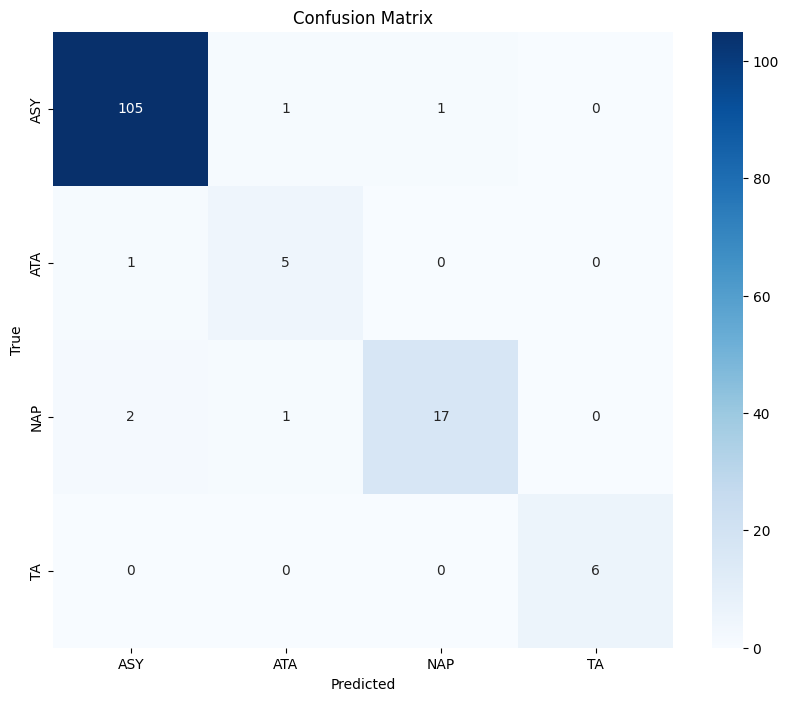

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predictions
y_val_probabilities = model.predict(X_val_final)
y_val_pred = np.argmax(y_val_probabilities, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
